In [1]:
import numpy as np
import pandas as pd
import hist
from hist import Hist
import awkward as ak
import json
import uproot
import math
from coffea import util
import pandas as pd
import pickle
from copy import copy, deepcopy

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

In [2]:
out_dir = "../data/github_examples/ddb_score"

with open("../data/xsec/xsec.json", "r") as json_file:
    xs = json.load(json_file)
    
total_lumi = 100 * 1000

# Table of contents <a class="anchor" id="toc"></a>

* [Find optimal DDB-score with number-counting](#ddb)
    * [One DDB-score for all pt ranges](#pt1)
    * [A unique DDB-score for each pt range](#pt2)

# Find optimal DDB score with number-counting <a class="anchor" id="ddb"></a>
[Back to Table of Contents](#toc)

In [3]:
mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]

In [4]:
def get_significance(S, B):
    
    return np.sqrt(2 * (S + B) * np.log(1 + S / B) - 2 * S)
    
def get_sel(h, process, pt1, pt2):
        
    alias = {
        "S" : hist.loc("ggF"),
        "B" : [hist.loc("ZH"), hist.loc("WH"), hist.loc("ttH"), hist.loc("VBF"),
               hist.loc("QCD"), hist.loc("TTbar"), hist.loc("ZJets"), hist.loc("W"), hist.loc("VV")],
    }
    
    sel = {
        "pt" : slice(hist.loc(pt1), hist.loc(pt2)),
        "mass" : slice(1, 2, sum),
        "process" : alias[process],
    }
    
    h = h[sel]
    
    if process == "B":
        h = h[{"process" : sum}]

    return h

def create_sig1(pt1=300, pt2=1200):
    
    S = get_sel(mc, "S", pt1, pt2)[{"pt" : slice(hist.loc(pt1), hist.loc(pt2) + 1, sum)}]       
    val_S = S.values()
    var_S = S.variances()
    S_cumsum = np.cumsum(val_S[::-1], axis=0)[::-1]

    B = get_sel(mc, "B", pt1, pt2)[{"pt" : slice(hist.loc(pt1), hist.loc(pt2) + 1, sum)}]
    val_B = B.values()
    B_cumsum = np.cumsum(val_B[::-1], axis=0)[::-1]

    sig = get_significance(S_cumsum, B_cumsum)

    Z = deepcopy(S)

    Z[:] = np.append(sig[:, np.newaxis], var_S[:, np.newaxis], axis=1)
    
    return Z

def create_sig2(pt1=300, pt2=1200):
    
    S = get_sel(mc, "S", pt1, pt2)
    val_S = S.values()
    var_S = S.variances()
    S_cumsum = np.cumsum(val_S[:, ::-1], axis=1)[:, ::-1]
    
    B = get_sel(mc, "B", pt1, pt2)
    val_B = B.values()
    B_cumsum = np.cumsum(val_B[:, ::-1], axis=1)[:, ::-1]

    sig = get_significance(S_cumsum, B_cumsum)
    
    Z = deepcopy(S)

    Z[:, :] = np.append(sig[:, :, np.newaxis], var_S[:, :, np.newaxis], axis=2)
    
    return Z

# One DDB-score for all pt ranges <a class="anchor" id="pt1"></a>
[Back to Table of Contents](#toc)

Text(0.05, 0.92, '300 < $p_T$ < 1200 GeV')

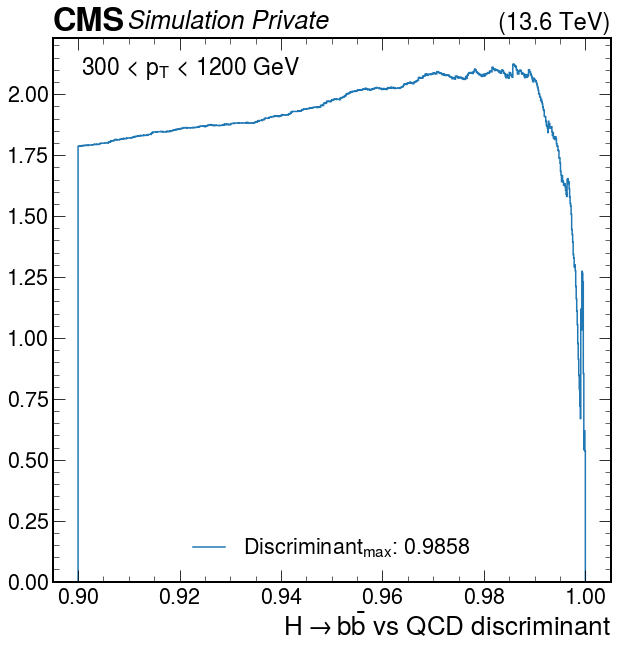

In [11]:
# This cell plots the distribution of the significance as a function 
# of double b-tagging discriminant score. The score that maximises
# the significance is listed in the legend.

plt.style.use(mplhep.style.CMS)

fig, ax = plt.subplots(
    1, 1, figsize=(10, 10))

pt1 = 300
pt2 = 1200

Z = create_sig1(pt1, pt2)
i_max = np.argmax(Z.values())
max_sig = Z.values()[i_max]
max_disc = Z.axes[0].edges[i_max]

# Z = Z / Z.sum().value

mplhep.histplot(
    Z,
    label = r"$Discriminant_{max}$:" + f" {max_disc:.4f}",
    ax=ax,
    yerr=False,
)

ax.legend(loc='lower center')
# ax.set_ylabel("Normalised to unit")
ax.set_xlabel(r'$H\rightarrow b\bar{b}$ vs QCD discriminant')

mplhep.cms.label(
    ax=ax, 
    data=False, 
    fontsize=25,
    label="Private",
#     year=2022,
#     com=13.6,
    rlabel="(13.6 TeV)"
)

plt.text(0.05, 0.92, f"{pt1:.0f} < " + r"$p_T$" + f" < {pt2:.0f} GeV",
    fontsize=23,
    horizontalalignment='left',
    verticalalignment='bottom',
    transform=ax.transAxes
)

# plt.savefig(f"Disc.pdf", bbox_inches='tight', pad_inches=0.1)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, '300 < $p_T$ < 350'),
  Text(1, 0, '350 < $p_T$ < 400'),
  Text(2, 0, '400 < $p_T$ < 450'),
  Text(3, 0, '450 < $p_T$ < 500'),
  Text(4, 0, '500 < $p_T$ < 600'),
  Text(5, 0, '550 < $p_T$ < 600'),
  Text(6, 0, '600 < $p_T$ < 675'),
  Text(7, 0, '675 < $p_T$ < 800'),
  Text(8, 0, '800 < $p_T$ < 1200')])

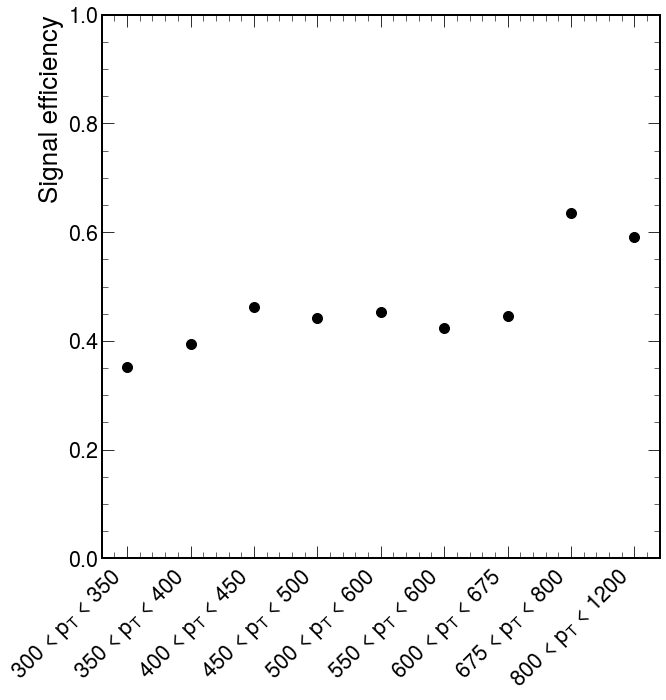

In [6]:
# This cell plots the signal efficiency after selecting the double b-tagging 
# discriminant score which maximises the significance, as a function of each pt-bin

plt.style.use(mplhep.style.CMS)

fig, ax = plt.subplots(figsize=(10, 10))

data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 20.,
    'color': 'k',
    'elinewidth': 1,
}

temp = mc[{
    "process" : hist.loc("ggF"),
    "mass" : slice(1, 2, sum),
}]

effs = []
for i, _ in enumerate(mc.project("pt").axes[0].centers):
    temp2 = temp[{"pt" : i}]
    effs.append(temp2[{"disc" : slice(i_max, len, sum)}].value / temp2[{"disc" : slice(0, len, sum)}].value)

ax.errorbar(
    [r"300 < $p_T$ < 350", r"350 < $p_T$ < 400", r"400 < $p_T$ < 450", r"450 < $p_T$ < 500",
     r"500 < $p_T$ < 600", r"550 < $p_T$ < 600", r"600 < $p_T$ < 675", r"675 < $p_T$ < 800",
     r"800 < $p_T$ < 1200"],
     effs,
    **data_err_opts,
)

# ax.set_yscale('log')

ax.set_ylim(0, 1)
ax.set_ylabel("Signal efficiency")
ax.set_xlabel("")
plt.xticks(rotation=45, ha='right')

# A unique DDB-score for each pt range <a class="anchor" id="pt2"></a>
[Back to Table of Contents](#toc)

/cvmfs/sft.cern.ch/lcg/views/LCG_104/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Private'))

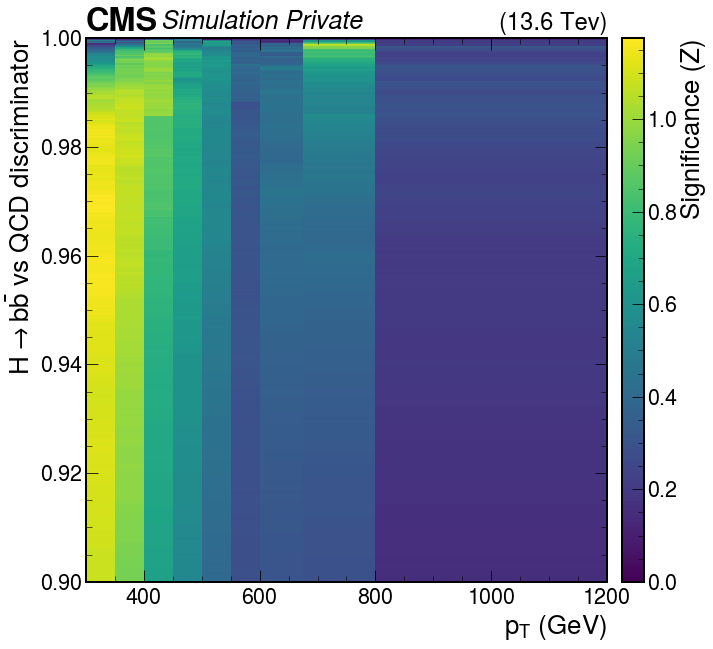

In [7]:
# This cell plots the distribution of the significance as a function of 
# double b-tagging discriminant score and pt. 

plt.style.use(mplhep.style.CMS)

fig, ax = plt.subplots(
    1, 1, figsize=(10, 10))


Z = create_sig2(300, 1200)

_, c, _ = mplhep.hist2dplot(
    Z.project("pt", "disc"),
    ax=ax,
    cbarsize="4%"
)

ylabel = c.set_label("Significance (Z)")

mplhep.cms.label(
    ax=ax, 
    data=False, 
    fontsize=25,
    label="Private",
#     year=2022,
#     com=13.6,
    rlabel="(13.6 Tev)"
)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, '300 < $p_T$ < 350'),
  Text(1, 0, '350 < $p_T$ < 400'),
  Text(2, 0, '400 < $p_T$ < 450'),
  Text(3, 0, '450 < $p_T$ < 500'),
  Text(4, 0, '500 < $p_T$ < 600'),
  Text(5, 0, '550 < $p_T$ < 600'),
  Text(6, 0, '600 < $p_T$ < 675'),
  Text(7, 0, '675 < $p_T$ < 800'),
  Text(8, 0, '800 < $p_T$ < 1200')])

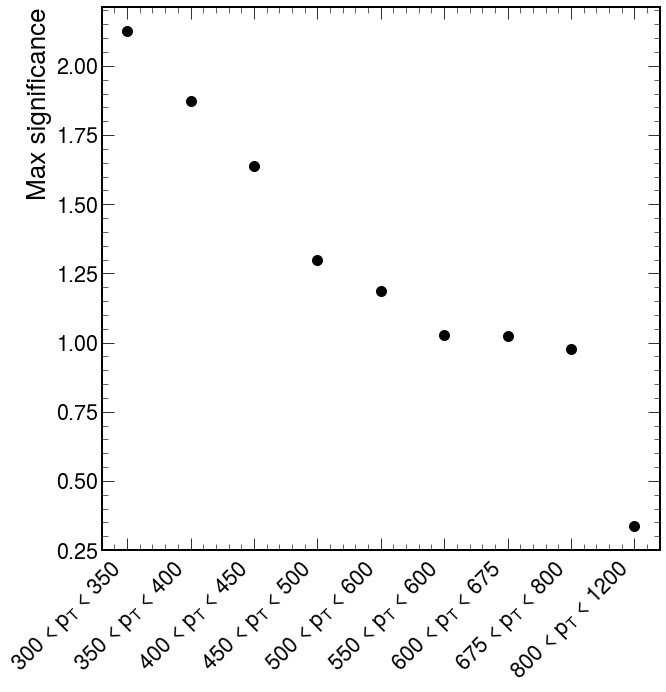

In [8]:
# This cell plots the maximal significance after selecting the double b-tagging 
# discriminant score which maximises the significance of each individual pt-bin

plt.style.use(mplhep.style.CMS)

fig, ax = plt.subplots(figsize=(10, 10))

data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 20.,
    'color': 'k',
    'elinewidth': 1,
}

max_sigs = []
is_max = []

pt_edges = mc.project("pt").axes[0].edges
#pt_edges = [300, 350, 400, 450, 500, 1200]

for i, pt1 in enumerate(pt_edges[:-1]):
    pt2 = pt_edges[i + 1]
    
    Z = create_sig1(pt1, pt2)
    
    i_max = np.argmax(Z.values())
    is_max.append(i_max)
    max_sigs.append(Z.values()[i_max])
    max_disc = Z.axes[0].edges[i_max]

ax.errorbar(
    [r"300 < $p_T$ < 350", r"350 < $p_T$ < 400", r"400 < $p_T$ < 450", r"450 < $p_T$ < 500",
     r"500 < $p_T$ < 600", r"550 < $p_T$ < 600", r"600 < $p_T$ < 675", r"675 < $p_T$ < 800",
     r"800 < $p_T$ < 1200"],
     max_sigs,
    **data_err_opts,
)

# ax.set_ylim(0, 2)
ax.set_ylabel("Max significance")
ax.set_xlabel("")
plt.xticks(rotation=45, ha='right')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, '300 < $p_T$ < 350'),
  Text(1, 0, '350 < $p_T$ < 400'),
  Text(2, 0, '400 < $p_T$ < 450'),
  Text(3, 0, '450 < $p_T$ < 500'),
  Text(4, 0, '500 < $p_T$ < 600'),
  Text(5, 0, '550 < $p_T$ < 600'),
  Text(6, 0, '600 < $p_T$ < 675'),
  Text(7, 0, '675 < $p_T$ < 800'),
  Text(8, 0, '800 < $p_T$ < 1200')])

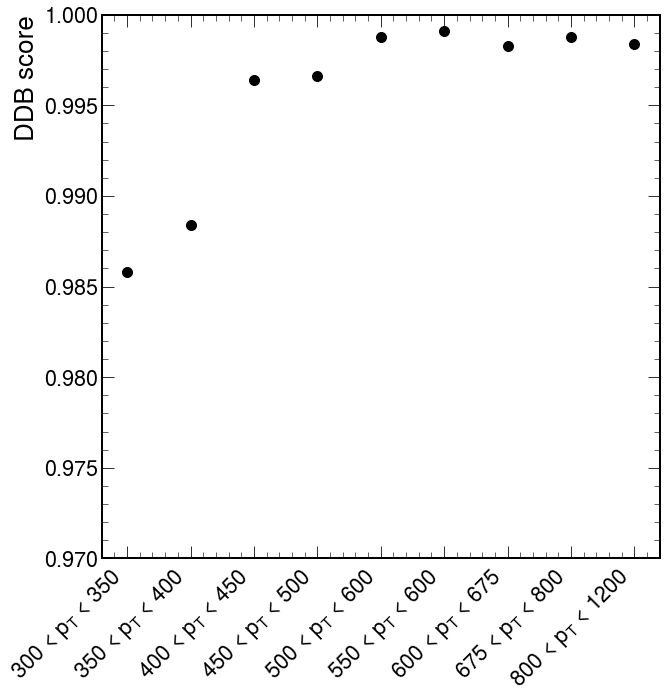

In [9]:
# This cell plots the  double b-tagging discriminant score which maximises 
# the significance of each individual pt-bin

plt.style.use(mplhep.style.CMS)

fig, ax = plt.subplots(figsize=(10, 10))

data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 20.,
    'color': 'k',
    'elinewidth': 1,
}

ax.errorbar(
    [r"300 < $p_T$ < 350", r"350 < $p_T$ < 400", r"400 < $p_T$ < 450", r"450 < $p_T$ < 500",
     r"500 < $p_T$ < 600", r"550 < $p_T$ < 600", r"600 < $p_T$ < 675", r"675 < $p_T$ < 800",
     r"800 < $p_T$ < 1200"],
    Z.project("disc").axes[0].edges[is_max],
    **data_err_opts,
)

ax.set_ylim(0.97, 1)
ax.set_ylabel("DDB score")
ax.set_xlabel("")
plt.xticks(rotation=45, ha='right')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, '300 < $p_T$ < 350'),
  Text(1, 0, '350 < $p_T$ < 400'),
  Text(2, 0, '400 < $p_T$ < 450'),
  Text(3, 0, '450 < $p_T$ < 500'),
  Text(4, 0, '500 < $p_T$ < 600'),
  Text(5, 0, '550 < $p_T$ < 600'),
  Text(6, 0, '600 < $p_T$ < 675'),
  Text(7, 0, '675 < $p_T$ < 800'),
  Text(8, 0, '800 < $p_T$ < 1200')])

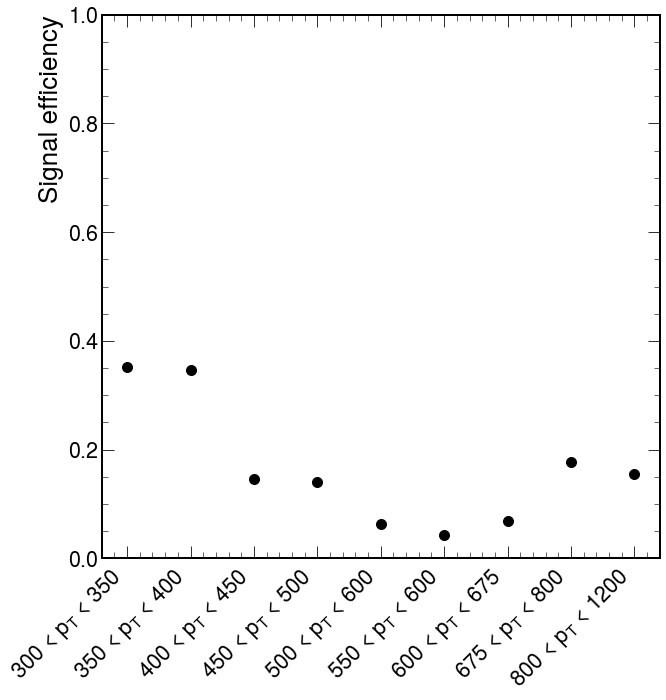

In [10]:
# This cell plots the signal efficiency after selecting the double b-tagging 
# discriminant score which maximises the significance of each individual pt-bin

plt.style.use(mplhep.style.CMS)

fig, ax = plt.subplots(figsize=(10, 10))

data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 20.,
    'color': 'k',
    'elinewidth': 1,
}

temp = mc[{
    "process" : hist.loc("ggF"),
    "mass" : slice(1, 2, sum),
}]

effs = []
for i, wp in enumerate(is_max):
    temp2 = temp[{"pt" : i}]
    effs.append(temp2[{"disc" : slice(wp, len, sum)}].value / temp2[{"disc" : slice(0, len, sum)}].value)

ax.errorbar(
    [r"300 < $p_T$ < 350", r"350 < $p_T$ < 400", r"400 < $p_T$ < 450", r"450 < $p_T$ < 500",
     r"500 < $p_T$ < 600", r"550 < $p_T$ < 600", r"600 < $p_T$ < 675", r"675 < $p_T$ < 800",
     r"800 < $p_T$ < 1200"],
     effs,
    **data_err_opts,
)

ax.set_ylim(0, 1)
ax.set_ylabel("Signal efficiency")
ax.set_xlabel("")
plt.xticks(rotation=45, ha='right')